# Tutorial of TRG in 2D
## Ising model on the square lattice

Here, the basic aspects of a simple tensor renormalization group ([TRG](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.99.120601)) are reviewed.

Computation of 
1. **Free energy** and **specific heat**
2. **CFT information** (central charge and scaling dimensions)

<u>This notebook is designed for beginners</u>. The algorithmic details are not explained.


In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm

from Levin_trg import *
PI=np.pi

## Set the initial tensor 
Set T to be the local Boltzmann weight of the Ising model. (See TRG.py)

Normalization factor is chosen so that the trace of the 4-leg tensor becomes unity.
## $$e^{-\beta{H}} = e^{\beta\sum_{i,j} \sigma_i\sigma_j}$$

In [2]:
# Initial tensor of the Ising model on the square lattice
# The local tensor resides on the plaquette of a sublattice A.
def initialize_Ising(T):
    # Make initial tensor of square lattice Ising model at a temperature T
    A =np.empty((2,2,2,2))
    
    for i in range(0,2):
        si = (i - 0.5) * 2
        for j in range(0,2):
            sj = (j - 0.5) * 2
            for k in range(0,2):
                sk = (k - 0.5) * 2
                for l in range(0,2):
                    sl = (l - 0.5) * 2
                    A[i,j,k,l] = np.exp((si*sj + sj*sk + sk*sl + sl*si)/T)
                    
    return A

In [3]:
# Ising model at criticality
Tc = 1./(1+np.log(2))
A = initialize_Ising(Tc)

# All you need for trying other models is to change the initial tensor!
# excercise : change the initial tensor to the three-state Potts model. Tc=1./np.log(1.+np.sqrt(3))

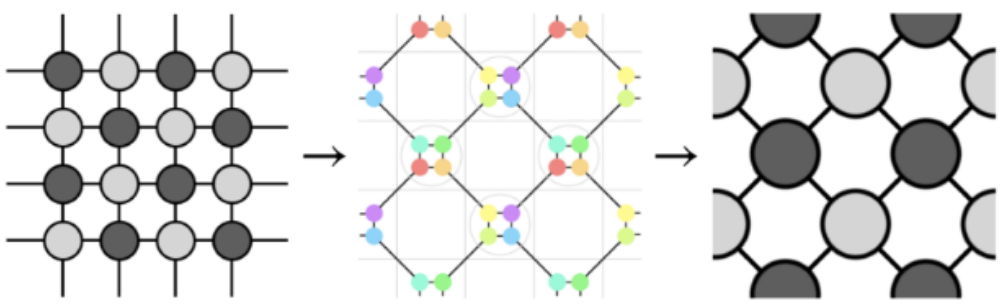



## Let's compute the free energy first!
(First as a black box)

In [4]:
# TRG_Square_Ising(T,D_cut,TRG_steps,Energy_flag)
# Calculation of the free energy.
D=16
RG_steps=50
T_list=np.linspace(2.0,2.4,40)
F_list=[]
for T in T_list:
    lnz = TRG_lnz(initialize_Ising(T),D,RG_steps)
    F_list.append(-T*lnz)

100%|███████████████████████████████████████████| 50/50 [00:00<00:00, 65.81it/s]


### The computed free energy is in *F_list*
#### Let us plot it!

Text(0, 0.5, 'Free energy')

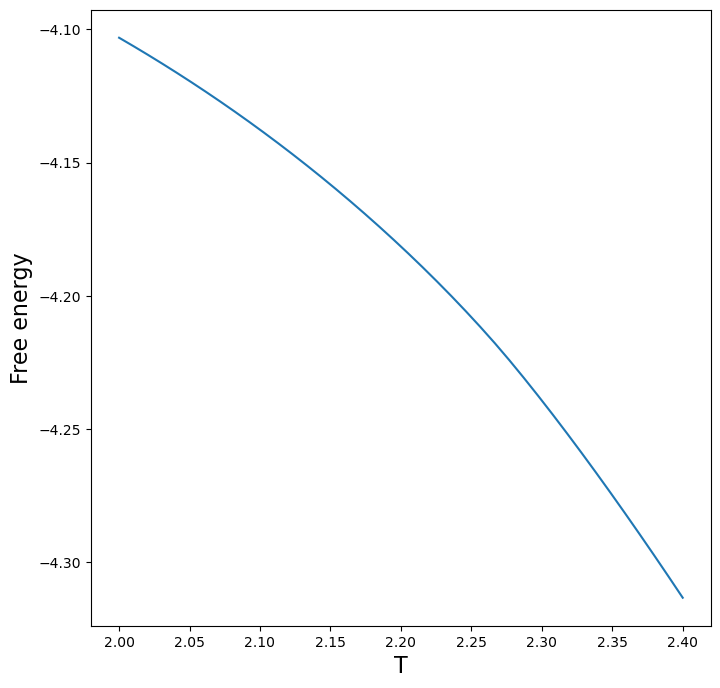

In [5]:
plt.figure(figsize=(8,8))
plt.plot(T_list,F_list)
plt.xlabel("T",fontsize=16)
plt.ylabel("Free energy",fontsize=16)

### One can obtain the heat capacity by numerical differenciating the free energy
### $$C = -T\frac{\partial^2F}{\partial^2T}$$

In [6]:
def Calculate_C(F_list,T_list):
    C_list = []
    deltaT = T_list[1]-T_list[0]
    for i in range(len(F_list)-2):
        C = (F_list[i+2]+F_list[i]-2*F_list[i+1])/deltaT**2
        C_list.append(-T_list[i+1]*C)
    return C_list

In [7]:
C_list = Calculate_C(F_list,T_list)

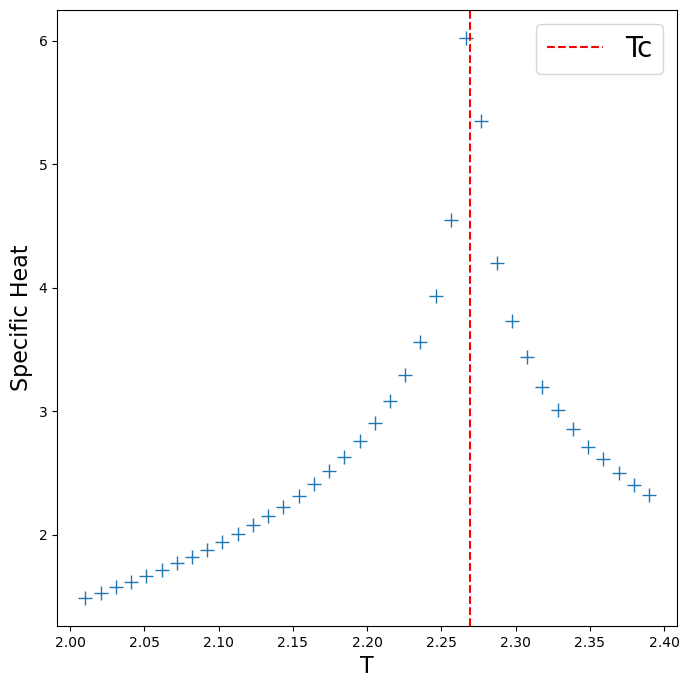

In [8]:
Tc=2./np.log(np.sqrt(2)+1)
plt.figure(figsize=(8,8))
plt.plot(T_list[1:-1],C_list,"+",markersize=10)
plt.axvline(Tc,color="red", linestyle='dashed',label="Tc")
plt.xlabel("T",fontsize=16)
plt.ylabel("Specific Heat",fontsize=16)
plt.legend(fontsize=20)




### Unpack the black box ー How to compute the free energy
In the TRG scheme, we often use the local Boltzmann weight as an initial tensor. The initial system size can be considered to be $L=1$. Thus, the trace of the initial tensor $T^{(0)}$ is
$$Tr\ T^{(0)} = Z(L=1)$$
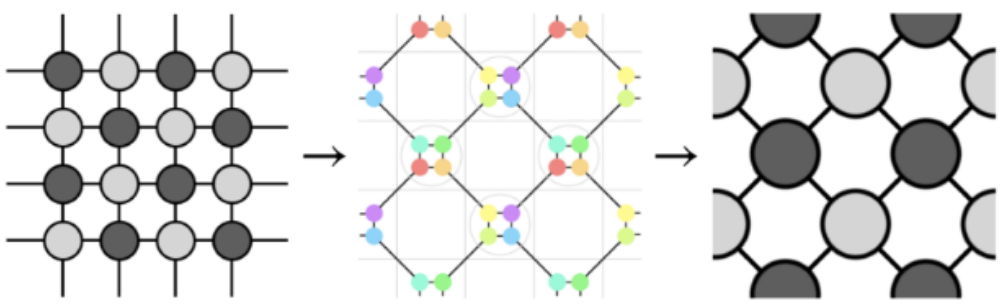
The effective system size after $n$-step is $L=\sqrt{2}^n$ as the RG transformation enlarge the system size by the factor of $\sqrt{2}$. Consequently, the trace of the trace of renormalized tensors is
$$Tr\ T^{(n)} = Z( L=\sqrt{2}^n )$$

In practice, we normalize the tensor each step to keep the numerical accuacy. Let us call the normalization factor at $n$-step $g_n$. The input for the RG transformation is $T^{(n-1)}/Z( L=\sqrt{2}^{(n-1)})$. As a result, the factor is found out to be 
$$g_n = Z( L=\sqrt{2}^n )/Z( L=\sqrt{2}^{(n-1)})^2$$


Using $g_n$, we can compute the free energy density as
$$F=-T\frac{1}{L^2}\log(Z( L=\sqrt{2}^n ))$$
$$= -T\frac{1}{2^n}\sum_{i=0}^n2^i(\log(Z( \sqrt{2}^{n-i} )) -2 \log(Z( \sqrt{2}^{(n-1-i)} )) $$
$$=-T\sum_{i=0}^n\frac{\log (g_i)}{2^i} $$
Due to the exponentially decaying factor, we can compute the free energy density by only considering finite $n$.

## Let us take a closer look
$g_n$ takes a trivial value for IR fixed point tensors. 
1. $g_n \rightarrow 1$ $(T>T_c)$

2. $g_n \rightarrow \frac{2}{2^2}=0.5$ $(T<T_c)$

In [9]:
# Calculate g_n, nested in "factor_list"
T = Tc + 0.5
D_cut = 16
RG_steps = 15
A = initialize_Ising(T)
A, factor = normalize_tensor(A)
factor_list=[factor]
A_list=[A]
for i in tqdm(range(RG_steps)):
    A = TRG_step(A,D_cut)
    A, factor = normalize_tensor(A)
    factor_list.append(factor)
    A_list.append(A)

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 64.84it/s]


In [10]:
# Quickly converges to 1.
factor_list

[8.950936445277852,
 0.5998511428555761,
 0.5341929656094675,
 0.6258353688977896,
 0.6384991416252083,
 0.7425320123824627,
 0.8336319120449416,
 0.9331048998149695,
 0.9826552193661486,
 0.9981414180884091,
 0.9999209683363737,
 0.9999817393223821,
 0.9999966308920692,
 1.0000007000620703,
 1.0000008061370942,
 1.0000008055929528]

In [11]:
# Z2 SSB phase
T = Tc - 0.5
D_cut = 16
RG_steps = 15
A = initialize_Ising(T)
A, factor = normalize_tensor(A)
factor_list=[factor]
A_list=[A]
for i in tqdm(range(RG_steps)):
    A = TRG_step(A,D_cut)
    A, factor = normalize_tensor(A)
    factor_list.append(factor)
    A_list.append(A)

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 63.78it/s]


In [12]:
# Quickly converges to 1/2.
factor_list

[19.39247360074856,
 0.5212727467152349,
 0.4910001960062495,
 0.5036574357352658,
 0.4982587898347787,
 0.499867599262642,
 0.49989793523878745,
 0.4999945313222994,
 0.4999999939703585,
 0.5000000742545528,
 0.5000000743475971,
 0.5000000743475683,
 0.500000074347524,
 0.5000000743474797,
 0.5000000743474358,
 0.5000000743473914]

## From "factor_list", the free energy density is computable

In [13]:
def cal_fenergy(T, factor_list):
    fenergy = 0
    for i in range(len(factor_list)):
        fenergy -= np.log(factor_list[i])/2**i
    return T*fenergy

In [14]:
# In the black box formula, the free energy density is half of this because the initial system size is actually √2
print(cal_fenergy(T,factor_list))

-4.049191426464184



## CFT information
When we contract the legs of $T^{(n)}$ in $x$-direction, it becomes the transfer matrix in $y$-direction with $L=\sqrt{2}^n$.

Using the classical-quantum correspondence and CFT in finite sizes, the eigenvalues $\lambda_i$ of the transfermatrix can be related to $\lambda_i=e^{-LE_i}$ 

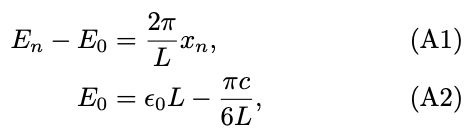

The scaling dimension can be computed from the ratio of the eigenvalues as
$$\frac{\lambda_n}{\lambda_0}= \exp(-2\pi x_n)$$.

As for the central charge, we obtain it from the leading eigenvalue $\lambda_0$.

$$Z(\sqrt{2}^{(n-1)}) = Tr\ exp(-2\pi(x_i-\frac{c}{12}) - \epsilon_0b^{2n-2})$$,
where $b=\sqrt{2}$.



For the fixed point tensor, it is reasonable to assume $c$ and $\epsilon_0$ to be ocnstant. Then, we get the central charge as below.
$$c = \frac{6}{\pi (b^2-1)}(b^2\ln\lambda_0^{(n-1)}-\ln\lambda_0^{(n)})$$

The [formula widely used](https://arxiv.org/abs/0903.1069) is 
$$c = \frac{6}{\pi}\left[-\frac{\ln g_n}{b^2-1}+\ln\frac{\lambda_0^{(n)}}{Z(n)}\right]$$
The second term is nothing but the leading eigenvalue of the normalized tensor. We need to compute the eigenvalue of $\frac{6}{\pi}T^{(n)}/g_n$.

## Scaling dimension

In [15]:
# Factor_list seem to converge at 10th RG step 
D_cut=28
RG_steps=10
A = initialize_Ising(Tc)
A, factor = normalize_tensor(A)
for i in range(RG_steps):
    A = TRG_step(A,D_cut)
    A, factor = normalize_tensor(A)
M=np.einsum("rurd->ud", A)
s=np.real(np.linalg.eigvals(M))
print("x1: ",np.log(s[0]/s[1])/2./(PI))
print("x2: ",np.log(s[0]/s[2])/2./(PI))

x1:  0.12492281873703791
x2:  1.0068231108487047


#### This is consistent with the CFT prediction
$$ x_1 = x_\sigma = 0.125$$
$$ x_2 = x_\epsilon = 1 $$

In [16]:
# A/Factor = T^{(n)}/g_n
D_cut = 28
RG_steps = 10
A = initialize_Ising(Tc)
A, factor = normalize_tensor(A)
for i in range(RG_steps):
    A = TRG_step(A,D_cut)
    A, factor = normalize_tensor(A)
M=np.einsum("rurd->ud", A/factor)
s=np.real(np.linalg.eigvals(M))
print("c : ",np.log(s[0])*6./(PI))

c :  0.5000844514007294


This is extremely consistent with $c=\frac{1}{2}$!

## To this end, we compute the central charge for a wide temperature range.
Only the critical region shall have non-zero values.

In [17]:
def central_charge(T):
    D_cut =16
    RG_steps =15
    A = initialize_Ising(T)
    A, factor =normalize_tensor(A)
    for i in range(RG_steps):
        A = TRG_step(A,D_cut)
        A, factor = normalize_tensor(A)
    M=np.einsum("rurd->ud",A/factor)
    u,s,v=np.linalg.svd(M)
    return np.log(s[0])*6./(PI)

In [18]:
T_list=np.linspace(1.8,2.8,100)
result = []
for T in tqdm(T_list):
    result.append(central_charge(T))
result=np.array(result)  

100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.17it/s]


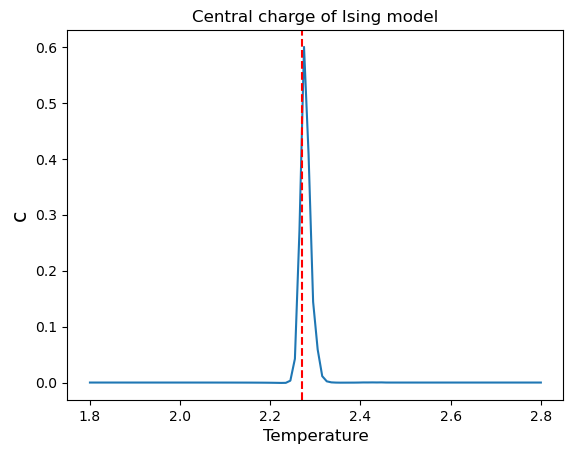

In [19]:
plt.plot(T_list,result)   
plt.axvline(Tc,color="red", linestyle='dashed')
plt.title("Central charge of Ising model")
plt.xlabel("Temperature",fontsize=12)
plt.ylabel("c",fontsize=15)
plt.savefig("ising_c.png")

## Excercise
**Can we observe $c=0.8$ for the three state Potts model?**


This can be done by changing the initial tensor to the three state Potts model and setting the temperature to critical $T_c=1/\log(1+\sqrt{3})$
## $$e^{-\beta{H}} = e^{\beta\sum_{i,j} \delta_{\sigma_i\sigma_j}},$$
where $\sigma_i = A,B,C$.